# ROI Summary by Slide and Group

This notebook aggregates ROI and cell counts (from `HE_ROI_Classification` outputs) by slide and by experimental group. It computes:

- Total detected cells per slide and per group
- Total detected ROIs (nuclei) per slide and per group
- Number of *internal* ROIs (nuclei) per slide and per group

Set `RESULTS_FOLDER` to the folder containing `*_roi_summary.csv` and `*_roi_details.csv` (default: `roi_analysis_results` next to your mask files). Run cells in order.

In [15]:
# 1) Imports and settings
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

# Path to results (change if necessary)
RESULTS_FOLDER = Path(r"S:\micro\ts2625\eh2888\lem\HEImages_0123\quantification\roi_analysis_results")
print(f"Looking for results in: {RESULTS_FOLDER}")


Looking for results in: S:\micro\ts2625\eh2888\lem\HEImages_0123\quantification\roi_analysis_results


In [16]:
# 2) Read available summary/details CSVs
# Prefer aggregated files if present
agg_summary = RESULTS_FOLDER / 'all_roi_summary_0204.csv'
agg_details = RESULTS_FOLDER / 'all_roi_details_0204.csv'

if agg_summary.exists():
    summary_df = pd.read_csv(agg_summary)
    print(f"Loaded aggregated summary: {agg_summary.name} | rows={len(summary_df)}")
else:
    # load all per-image *_roi_summary.csv files
    files = sorted(RESULTS_FOLDER.glob('*_roi_summary.csv'))
    if not files:
        raise FileNotFoundError(f"No summary CSVs found in {RESULTS_FOLDER}")
    df_list = [pd.read_csv(f) for f in files]
    summary_df = pd.concat(df_list, ignore_index=True)
    print(f"Loaded {len(files)} per-image summary files | total rows={len(summary_df)}")

# Details (to count 'internal' if not present in summary)
if agg_details.exists():
    details_df = pd.read_csv(agg_details)
    print(f"Loaded aggregated details: {agg_details.name} | rows={len(details_df)}")
else:
    files = sorted(RESULTS_FOLDER.glob('*_roi_details.csv'))
    if not files:
        # details optional - will compute internal from summary if present
        details_df = None
        print("No per-image details found; continuing with summary only.")
    else:
        df_list = [pd.read_csv(f) for f in files]
        details_df = pd.concat(df_list, ignore_index=True)
        print(f"Loaded {len(files)} per-image details files | total rows={len(details_df)}")

summary_df.head()

Loaded aggregated summary: all_roi_summary_0204.csv | rows=78
Loaded aggregated details: all_roi_details_0204.csv | rows=4042


,image_base,orig_num_cells,removed_small_cells,num_cells,num_rois,n_internal,n_edge,n_outside
0,01_01_02_0,77,2,77,32,0,27,5
1,01_01_02_1,96,11,92,56,0,55,1
2,01_01_03_0,50,0,50,25,0,25,0
3,01_01_03_1,53,2,52,21,1,18,2
4,01_01_04_0,53,0,53,22,0,22,0


In [17]:
# 3) Parse filename base into slide/region/subregion and assign group mapping
import re

def parse_base_to_parts(base_str):
    """Parse a base string like '01_01_02_0' -> dict with slide, region, subregion"""
    parts = re.split('[_\-]', base_str)
    # Expect at least 4 parts; if not, try to find numeric parts
    nums = [p for p in parts if p.isdigit()]
    # pad with None
    while len(nums) < 4:
        nums.append(None)
    return {
        'orig': base_str,
        'part0': parts[0] if len(parts)>0 else None,
        'slide': int(nums[1]) if nums[1] is not None else None,
        'region': int(nums[2]) if nums[2] is not None else None,
        'subregion': int(nums[3]) if nums[3] is not None else None
    }


def slide_to_group(slide):
    """Map slide number to group name per project rules.

    For the HSA groups we put "LR" as a superscript over "HSA" using
    matplotlib mathtext (e.g., r'HSA$^{\\mathrm{LR}}$-CLAAAV').
    """
    if slide in (1,2,3,4):
        return 'WT-Saline'
    if slide in (5,6,7,8):
        return r'HSA$^{\mathrm{LR}}$-Saline'
    if slide in (9,10,11,12,13):
        return r'HSA$^{\mathrm{LR}}$-CLAAAV'
    return 'Unknown'

# Apply parsing to summary df
if 'image_base' in summary_df.columns:
    summary_df['base'] = summary_df['image_base']
else:
    # try to find a basename column
    for c in summary_df.columns:
        if 'base' in c:
            summary_df['base'] = summary_df[c]
            break

parsed = summary_df['base'].apply(parse_base_to_parts).apply(pd.Series)
summary_df = pd.concat([summary_df, parsed], axis=1)
summary_df['group'] = summary_df['slide'].apply(lambda s: slide_to_group(int(s)) if not pd.isna(s) else 'Unknown')

# Filter out slide 15
summary_df = summary_df[summary_df['slide'] != 15]
print(f"Filtered out slide 15. Remaining rows: {len(summary_df)}")

# Also add parsed fields for details_df if present
if details_df is not None:
    if 'image_base' in details_df.columns:
        details_df['base'] = details_df['image_base']
    parsed_d = details_df['base'].apply(parse_base_to_parts).apply(pd.Series)
    details_df = pd.concat([details_df, parsed_d], axis=1)
    details_df['group'] = details_df['slide'].apply(lambda s: slide_to_group(int(s)) if not pd.isna(s) else 'Unknown')
    
    # Filter out slide 15 from details as well
    details_df = details_df[details_df['slide'] != 15]
    print(f"Filtered out slide 15 from details. Remaining rows: {len(details_df)}")

summary_df.head()


Filtered out slide 15. Remaining rows: 75


<>:6: SyntaxWarning: invalid escape sequence '\-'
<>:6: SyntaxWarning: invalid escape sequence '\-'
C:\Users\zyu\AppData\Local\Temp\ipykernel_20784\4184485578.py:6: SyntaxWarning: invalid escape sequence '\-'
  parts = re.split('[_\-]', base_str)


Filtered out slide 15 from details. Remaining rows: 3835


,image_base,orig_num_cells,removed_small_cells,num_cells,num_rois,n_internal,n_edge,n_outside,base,orig,part0,slide,region,subregion,group
0,01_01_02_0,77,2,77,32,0,27,5,01_01_02_0,01_01_02_0,01,1,2,0,WT-Saline
1,01_01_02_1,96,11,92,56,0,55,1,01_01_02_1,01_01_02_1,01,1,2,1,WT-Saline
2,01_01_03_0,50,0,50,25,0,25,0,01_01_03_0,01_01_03_0,01,1,3,0,WT-Saline
3,01_01_03_1,53,2,52,21,1,18,2,01_01_03_1,01_01_03_1,01,1,3,1,WT-Saline
4,01_01_04_0,53,0,53,22,0,22,0,01_01_04_0,01_01_04_0,01,1,4,0,WT-Saline


In [18]:
# 4) Aggregate per slide and per group
# Use summary_df (prefer provided n_internal column). If not present, compute internal from details_df.

# Ensure fields exist
if 'num_cells' not in summary_df.columns and 'num_cells' in summary_df.columns:
    pass

if 'n_internal' not in summary_df.columns and details_df is not None:
    # compute n_internal per base from details
    intr = details_df[details_df['classification']=='internal'].groupby('base').size().rename('n_internal')
    summary_df = summary_df.merge(intr, how='left', left_on='base', right_index=True)
    summary_df['n_internal'] = summary_df['n_internal'].fillna(0).astype(int)

# Fill missing numeric columns if needed
for col in ['num_cells','num_rois','n_internal']:
    if col not in summary_df.columns:
        summary_df[col] = 0

# Per-slide aggregation
slide_agg = summary_df.groupby('slide').agg(
    slides_count=('base','nunique'),
    total_cells=('num_cells','sum'),
    total_rois=('num_rois','sum'),
    total_internal=('n_internal','sum')
).reset_index()
slide_agg['group'] = slide_agg['slide'].apply(slide_to_group)

# Per-group aggregation
group_agg = slide_agg.groupby('group').agg(
    slides_count=('slide','nunique'),
    total_cells=('total_cells','sum'),
    total_rois=('total_rois','sum'),
    total_internal=('total_internal','sum')
).reset_index()

print('Per-slide summary:')
print(slide_agg)
print('\nPer-group summary:')
print(group_agg)


Per-slide summary:
    slide  slides_count  total_cells  total_rois  total_internal  \
0       1             9          600         317               2   
1       2             6          570         271               1   
2       3             6          343         175               0   
3       4             2          111          47               1   
4       5             6          462         451              40   
5       6             3          221         133              15   
6       7             9          643         734             203   
7       8            10          650         732             164   
8       9             8          676         323              11   
9      10             4          330          78               3   
10     11             4          417         275               3   
11     12             3          198         138               4   
12     13             5          274         161               0   

                         gro

C:\Users\zyu\AppData\Local\Temp\ipykernel_20784\1557432931.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=slide_agg.sort_values('slide'), x='slide', y='total_cells', ax=axes[0], palette='Blues_d')
C:\Users\zyu\AppData\Local\Temp\ipykernel_20784\1557432931.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=slide_agg.sort_values('slide'), x='slide', y='total_rois', ax=axes[1], palette='Greens_d')
C:\Users\zyu\AppData\Local\Temp\ipykernel_20784\1557432931.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=slide_agg.sort_

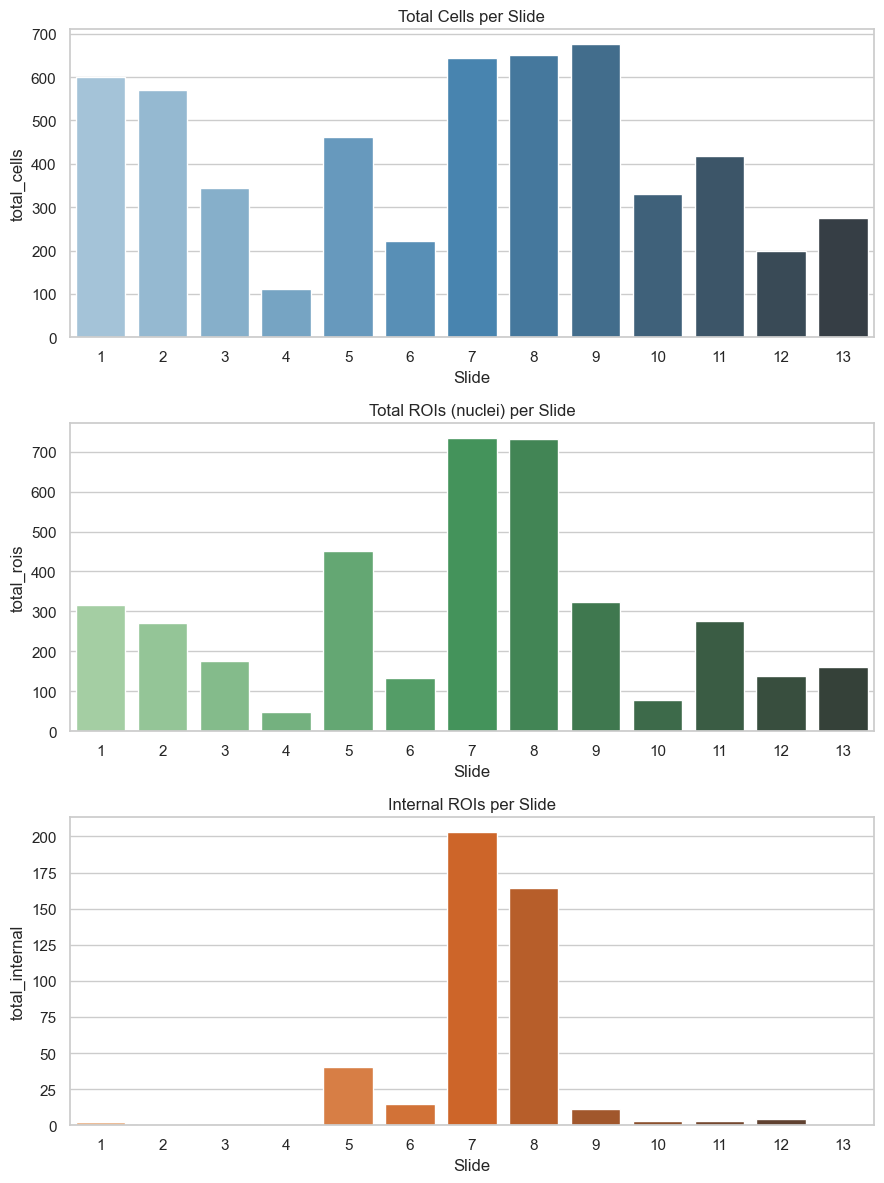

C:\Users\zyu\AppData\Local\Temp\ipykernel_20784\1557432931.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group_agg, x='group', y='total_cells', ax=ax[0], palette='Blues_d')
C:\Users\zyu\AppData\Local\Temp\ipykernel_20784\1557432931.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group_agg, x='group', y='total_rois', ax=ax[1], palette='Greens_d')
C:\Users\zyu\AppData\Local\Temp\ipykernel_20784\1557432931.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group_agg, x='group', y='total_internal', ax=ax[2], palette=

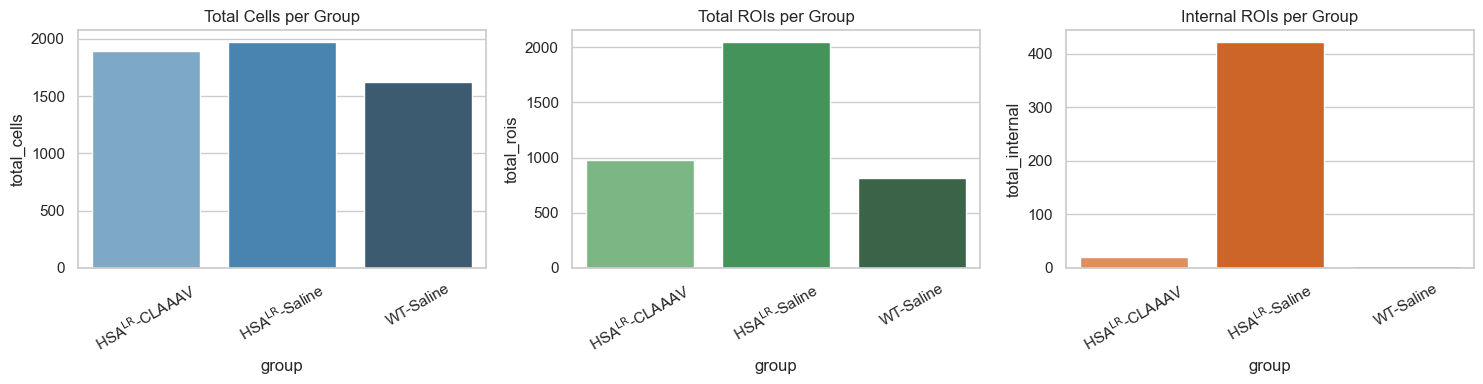

In [19]:
# 5) Visualizations
fig, axes = plt.subplots(3,1, figsize=(9,12))

# Cells per slide
sns.barplot(data=slide_agg.sort_values('slide'), x='slide', y='total_cells', ax=axes[0], palette='Blues_d')
axes[0].set_title('Total Cells per Slide')
axes[0].set_xlabel('Slide')

# ROIs per slide
sns.barplot(data=slide_agg.sort_values('slide'), x='slide', y='total_rois', ax=axes[1], palette='Greens_d')
axes[1].set_title('Total ROIs (nuclei) per Slide')
axes[1].set_xlabel('Slide')

# Internal ROIs per slide
sns.barplot(data=slide_agg.sort_values('slide'), x='slide', y='total_internal', ax=axes[2], palette='Oranges_d')
axes[2].set_title('Internal ROIs per Slide')
axes[2].set_xlabel('Slide')

plt.tight_layout()
plt.show()

# Group-level plots
fig, ax = plt.subplots(1,3, figsize=(15,4))

sns.barplot(data=group_agg, x='group', y='total_cells', ax=ax[0], palette='Blues_d')
ax[0].set_title('Total Cells per Group')
ax[0].tick_params(axis='x', rotation=30)

sns.barplot(data=group_agg, x='group', y='total_rois', ax=ax[1], palette='Greens_d')
ax[1].set_title('Total ROIs per Group')
ax[1].tick_params(axis='x', rotation=30)

sns.barplot(data=group_agg, x='group', y='total_internal', ax=ax[2], palette='Oranges_d')
ax[2].set_title('Internal ROIs per Group')
ax[2].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()


In [20]:
# 6) Save summary tables
out_dir = RESULTS_FOLDER
slide_agg.to_csv(out_dir / 'summary_per_slide2.csv', index=False)
group_agg.to_csv(out_dir / 'summary_per_group2.csv', index=False)
print(f"Saved slide summary to: {out_dir / 'summary_per_slide.csv'}")
print(f"Saved group summary to: {out_dir / 'summary_per_group.csv'}")


Saved slide summary to: S:\micro\ts2625\eh2888\lem\HEImages_0123\quantification\roi_analysis_results\summary_per_slide.csv
Saved group summary to: S:\micro\ts2625\eh2888\lem\HEImages_0123\quantification\roi_analysis_results\summary_per_group.csv


C:\Users\zyu\AppData\Local\Temp\ipykernel_20784\15067298.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=plot_df, x='group', y='count', hue='type', order=order, ci=None, palette=['#4C72B0', '#DD8452'])


Saved combined plot to: S:\micro\ts2625\eh2888\lem\HEImages_0123\quantification\roi_analysis_results\group_rois_total_internal.png


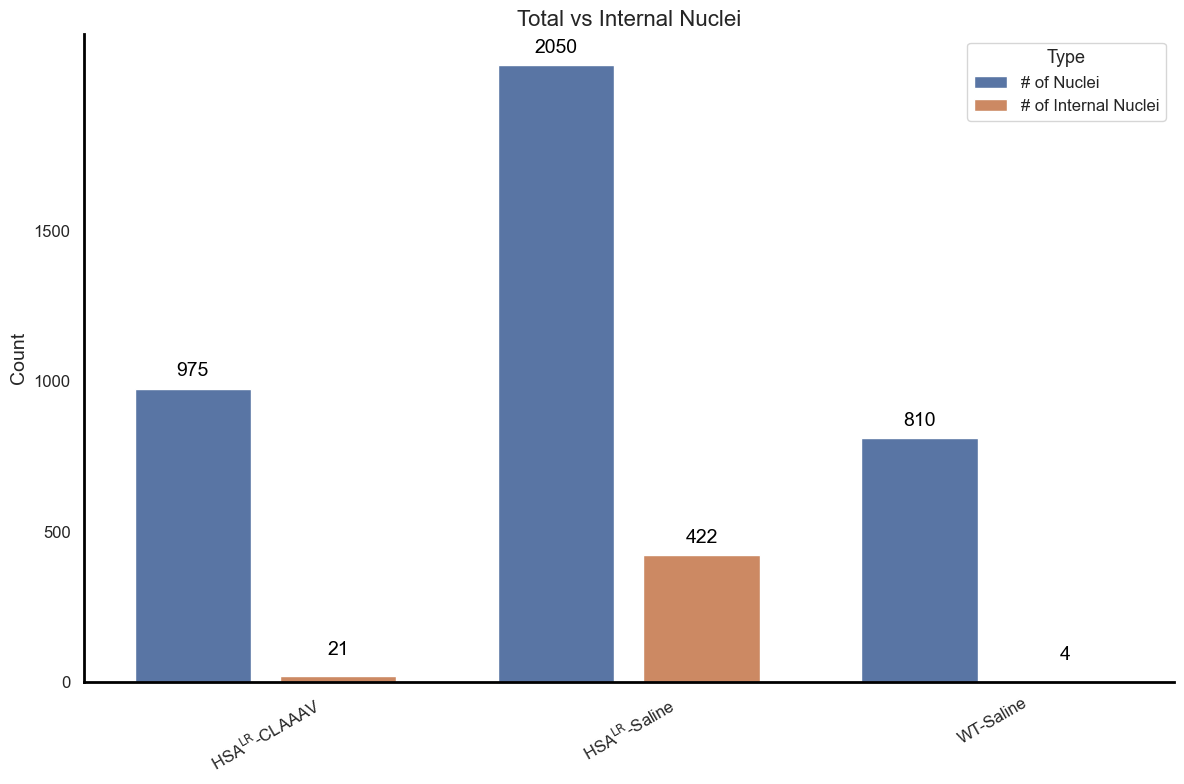

In [21]:
# 7) Combined plot: Total ROIs and Internal ROIs per group (updated style)
if 'group_agg' not in globals():
    raise RuntimeError('group_agg not found - run the aggregation cells first')

# Prepare data for plotting
plot_df = group_agg[['group', 'total_rois', 'total_internal']].melt(id_vars='group', value_vars=['total_rois', 'total_internal'],
                                                                      var_name='type', value_name='count')
plot_df['type'] = plot_df['type'].map({'total_rois': '# of Nuclei', 'total_internal': '# of Internal Nuclei'})

# Plot grouped bars with cleaner style
sns.set_style('white')  # no grid
plt.figure(figsize=(12,8))
order = group_agg['group'].tolist()
ax = sns.barplot(data=plot_df, x='group', y='count', hue='type', order=order, ci=None, palette=['#4C72B0', '#DD8452'])
# Title and labels with larger fonts
ax.set_title('Total vs Internal Nuclei', fontsize=16)
# remove x-axis label per request
ax.set_xlabel('')
ax.set_ylabel('Count', fontsize=14)
# Increase tick label size
ax.tick_params(axis='x', rotation=30, labelsize=12)
ax.tick_params(axis='y', labelsize=12, width=2)
ax.grid(False)

# Ensure left and bottom spines are visible (restore axis line) and hide top/right
ax.spines['left'].set_visible(True)
# increase left spine thickness
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Increase tick width for y axis to match thicker spine
ax.tick_params(axis='y', width=2)
# Use seaborn helper to remove top/right spines while preserving left/bottom
sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)

# Make bars narrower
for p in ax.patches:
    current_width = p.get_width()
    new_width = current_width * 0.8
    diff = current_width - new_width
    p.set_width(new_width)
    p.set_x(p.get_x() + diff / 2)

# Set y-axis ticks explicitly
ymax = max(1600, plot_df['count'].max() * 1.05)
ax.set_ylim(0, ymax)
ax.set_yticks([0, 500, 1000, 1500])

# Add labels on top of bars (skip zero-height bars to avoid stray '0' marks; use clip_on=False)
for p in ax.patches:
    height = p.get_height()
    if np.isnan(height) or height <= 0:
        continue
    # Increase offset for very small bars to avoid collision with nearby text
    offset = 6 if height >= 50 else 12
    ax.annotate(f'{int(round(height))}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=14, color='black', xytext=(0, offset),
                textcoords='offset points', clip_on=False, zorder=10)

# Larger legend text
ax.legend(title='Type', fontsize=12, title_fontsize=13)
plt.tight_layout()

# Save figure
out_path = RESULTS_FOLDER / 'group_rois_total_internal.png'
plt.savefig(out_path, dpi=600, bbox_inches='tight')
print(f"Saved combined plot to: {out_path}")

Ratios per slide:
    slide                       group  total_cells  total_rois  \
0       1                   WT-Saline          600         317   
1       2                   WT-Saline          570         271   
2       3                   WT-Saline          343         175   
3       4                   WT-Saline          111          47   
4       5  HSA$^{\mathrm{LR}}$-Saline          462         451   
5       6  HSA$^{\mathrm{LR}}$-Saline          221         133   
6       7  HSA$^{\mathrm{LR}}$-Saline          643         734   
7       8  HSA$^{\mathrm{LR}}$-Saline          650         732   
8       9  HSA$^{\mathrm{LR}}$-CLAAAV          676         323   
9      10  HSA$^{\mathrm{LR}}$-CLAAAV          330          78   
10     11  HSA$^{\mathrm{LR}}$-CLAAAV          417         275   
11     12  HSA$^{\mathrm{LR}}$-CLAAAV          198         138   
12     13  HSA$^{\mathrm{LR}}$-CLAAAV          274         161   

    total_internal  nuclei_per_cell  internal_ratio_pct  

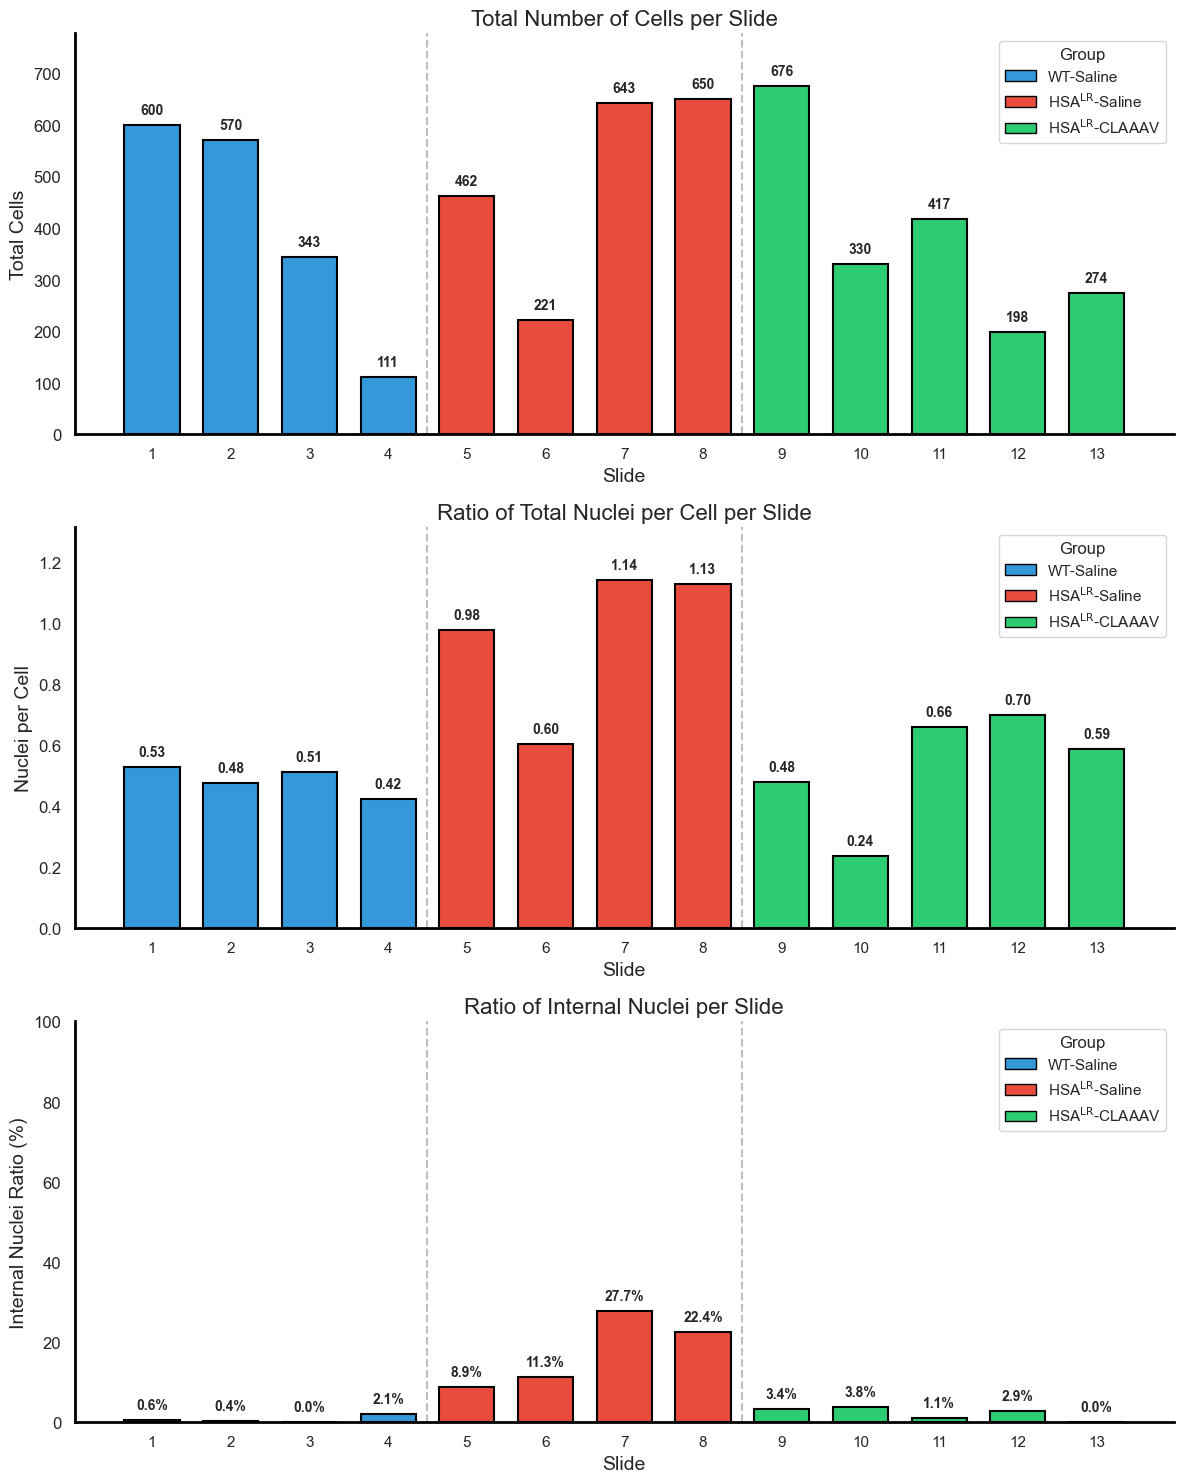


Total cells summary by group:
                             sum   mean         std  min  max
group                                                        
HSA$^{\mathrm{LR}}$-CLAAAV  1895  379.0  184.282392  198  676
HSA$^{\mathrm{LR}}$-Saline  1976  494.0  201.734148  221  650
WT-Saline                   1624  406.0  227.688384  111  600

Nuclei per cell summary by group:
                                mean       std       min       max
group                                                             
HSA$^{\mathrm{LR}}$-CLAAAV  0.531642  0.184994  0.236364  0.696970
HSA$^{\mathrm{LR}}$-Saline  0.961420  0.251073  0.601810  1.141524
WT-Saline                   0.484350  0.046168  0.423423  0.528333

Internal ratio summary by group:
                                 mean       std      min        max
group                                                              
HSA$^{\mathrm{LR}}$-CLAAAV   2.248237  1.636280  0.00000   3.846154
HSA$^{\mathrm{LR}}$-Saline  17.552106  8.951759  8.

In [26]:
# 8) Ratio of Internal Nuclei per Slide, grouped by experimental group
# Calculate the ratio of internal nuclei to total nuclei for each slide
slide_agg['internal_ratio'] = slide_agg['total_internal'] / slide_agg['total_rois']
slide_agg['internal_ratio_pct'] = slide_agg['internal_ratio'] * 100

# Calculate nuclei per cell ratio
slide_agg['nuclei_per_cell'] = slide_agg['total_rois'] / slide_agg['total_cells']

print('Ratios per slide:')
print(slide_agg[['slide', 'group', 'total_cells', 'total_rois', 'total_internal', 'nuclei_per_cell', 'internal_ratio_pct']])

# Create visualization with three subplots
sns.set_style('white')
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Plot bars for each slide, colored by group
order = ['WT-Saline', r'HSA$^{\mathrm{LR}}$-Saline', r'HSA$^{\mathrm{LR}}$-CLAAAV']
palette = {'WT-Saline': '#3498db', r'HSA$^{\mathrm{LR}}$-Saline': '#e74c3c', r'HSA$^{\mathrm{LR}}$-CLAAAV': '#2ecc71'}

# Sort by group order, then by slide number within group
slide_agg_sorted = slide_agg.copy()
slide_agg_sorted['group_order'] = slide_agg_sorted['group'].map({g: i for i, g in enumerate(order)})
slide_agg_sorted = slide_agg_sorted.sort_values(['group_order', 'slide'])

# ===== SUBPLOT 1: Total Cells per Slide ===== 
ax = axes[0]
bars = ax.bar(range(len(slide_agg_sorted)), slide_agg_sorted['total_cells'], 
               color=[palette.get(g, '#95a5a6') for g in slide_agg_sorted['group']], 
               edgecolor='black', linewidth=1.5, width=0.7)

# Customize plot
ax.set_xlabel('Slide', fontsize=14)
ax.set_ylabel('Total Cells', fontsize=14)
ax.set_title('Total Number of Cells per Slide', fontsize=16)
ax.set_xticks(range(len(slide_agg_sorted)))
ax.set_xticklabels(slide_agg_sorted['slide'].astype(int), fontsize=11)
ax.tick_params(axis='y', labelsize=12, width=2)

# Set y-axis range dynamically
ymax = slide_agg_sorted['total_cells'].max() * 1.15
ax.set_ylim(0, ymax)

# Adjust spines
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)

# Add value labels on top of bars
for i, (idx, row) in enumerate(slide_agg_sorted.iterrows()):
    ax.text(i, row['total_cells'] + ymax*0.02, f"{int(row['total_cells'])}", 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=palette[g], edgecolor='black', label=g) for g in order if g in slide_agg_sorted['group'].values]
ax.legend(handles=legend_elements, title='Group', fontsize=11, title_fontsize=12, loc='upper right')

# Add group separators
current_group = None
for i, (idx, row) in enumerate(slide_agg_sorted.iterrows()):
    if row['group'] != current_group:
        if i > 0:
            ax.axvline(x=i-0.5, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
        current_group = row['group']

# ===== SUBPLOT 2: Nuclei per Cell Ratio ===== 
ax2 = axes[1]
bars2 = ax2.bar(range(len(slide_agg_sorted)), slide_agg_sorted['nuclei_per_cell'], 
                color=[palette.get(g, '#95a5a6') for g in slide_agg_sorted['group']], 
                edgecolor='black', linewidth=1.5, width=0.7)

# Customize plot
ax2.set_xlabel('Slide', fontsize=14)
ax2.set_ylabel('Nuclei per Cell', fontsize=14)
ax2.set_title('Ratio of Total Nuclei per Cell per Slide', fontsize=16)
ax2.set_xticks(range(len(slide_agg_sorted)))
ax2.set_xticklabels(slide_agg_sorted['slide'].astype(int), fontsize=11)
ax2.tick_params(axis='y', labelsize=12, width=2)

# Set y-axis range dynamically
ymax2 = slide_agg_sorted['nuclei_per_cell'].max() * 1.15
ax2.set_ylim(0, ymax2)

# Adjust spines
ax2.spines['left'].set_linewidth(2)
ax2.spines['left'].set_color('black')
ax2.spines['bottom'].set_linewidth(2)
ax2.spines['bottom'].set_color('black')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
sns.despine(ax=ax2, top=True, right=True, left=False, bottom=False)

# Add value labels on top of bars
for i, (idx, row) in enumerate(slide_agg_sorted.iterrows()):
    ax2.text(i, row['nuclei_per_cell'] + ymax2*0.02, f"{row['nuclei_per_cell']:.2f}", 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add legend
legend_elements2 = [Patch(facecolor=palette[g], edgecolor='black', label=g) for g in order if g in slide_agg_sorted['group'].values]
ax2.legend(handles=legend_elements2, title='Group', fontsize=11, title_fontsize=12, loc='upper right')

# Add group separators
current_group = None
for i, (idx, row) in enumerate(slide_agg_sorted.iterrows()):
    if row['group'] != current_group:
        if i > 0:
            ax2.axvline(x=i-0.5, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
        current_group = row['group']

# ===== SUBPLOT 3: Internal Nuclei Ratio ===== 
ax3 = axes[2]
bars3 = ax3.bar(range(len(slide_agg_sorted)), slide_agg_sorted['internal_ratio_pct'], 
                color=[palette.get(g, '#95a5a6') for g in slide_agg_sorted['group']], 
                edgecolor='black', linewidth=1.5, width=0.7)

# Customize plot
ax3.set_xlabel('Slide', fontsize=14)
ax3.set_ylabel('Internal Nuclei Ratio (%)', fontsize=14)
ax3.set_title('Ratio of Internal Nuclei per Slide', fontsize=16)
ax3.set_xticks(range(len(slide_agg_sorted)))
ax3.set_xticklabels(slide_agg_sorted['slide'].astype(int), fontsize=11)
ax3.tick_params(axis='y', labelsize=12, width=2)

# Set y-axis range
ax3.set_ylim(0, 100)
ax3.set_yticks([0, 20, 40, 60, 80, 100])

# Adjust spines
ax3.spines['left'].set_linewidth(2)
ax3.spines['left'].set_color('black')
ax3.spines['bottom'].set_linewidth(2)
ax3.spines['bottom'].set_color('black')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
sns.despine(ax=ax3, top=True, right=True, left=False, bottom=False)

# Add value labels on top of bars
for i, (idx, row) in enumerate(slide_agg_sorted.iterrows()):
    ax3.text(i, row['internal_ratio_pct'] + 2, f"{row['internal_ratio_pct']:.1f}%", 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add legend
legend_elements3 = [Patch(facecolor=palette[g], edgecolor='black', label=g) for g in order if g in slide_agg_sorted['group'].values]
ax3.legend(handles=legend_elements3, title='Group', fontsize=11, title_fontsize=12, loc='upper right')

# Add group separators
current_group = None
for i, (idx, row) in enumerate(slide_agg_sorted.iterrows()):
    if row['group'] != current_group:
        if i > 0:
            ax3.axvline(x=i-0.5, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
        current_group = row['group']

plt.tight_layout()

# Save figure
out_path = RESULTS_FOLDER / 'ratio_analysis_per_slide.png'
plt.savefig(out_path, dpi=600, bbox_inches='tight')
print(f"\nSaved ratio analysis plot to: {out_path}")
plt.show()

# Summary statistics by group
print('\nTotal cells summary by group:')
cells_summary = slide_agg.groupby('group')['total_cells'].agg(['sum', 'mean', 'std', 'min', 'max'])
print(cells_summary)

print('\nNuclei per cell summary by group:')
nuclei_per_cell_summary = slide_agg.groupby('group')['nuclei_per_cell'].agg(['mean', 'std', 'min', 'max'])
print(nuclei_per_cell_summary)

print('\nInternal ratio summary by group:')
ratio_summary = slide_agg.groupby('group')['internal_ratio_pct'].agg(['mean', 'std', 'min', 'max'])
print(ratio_summary)


Saved box plot to: S:\micro\ts2625\eh2888\lem\HEImages_0123\quantification\roi_analysis_results\boxplot_nuclei_metrics_by_group.png


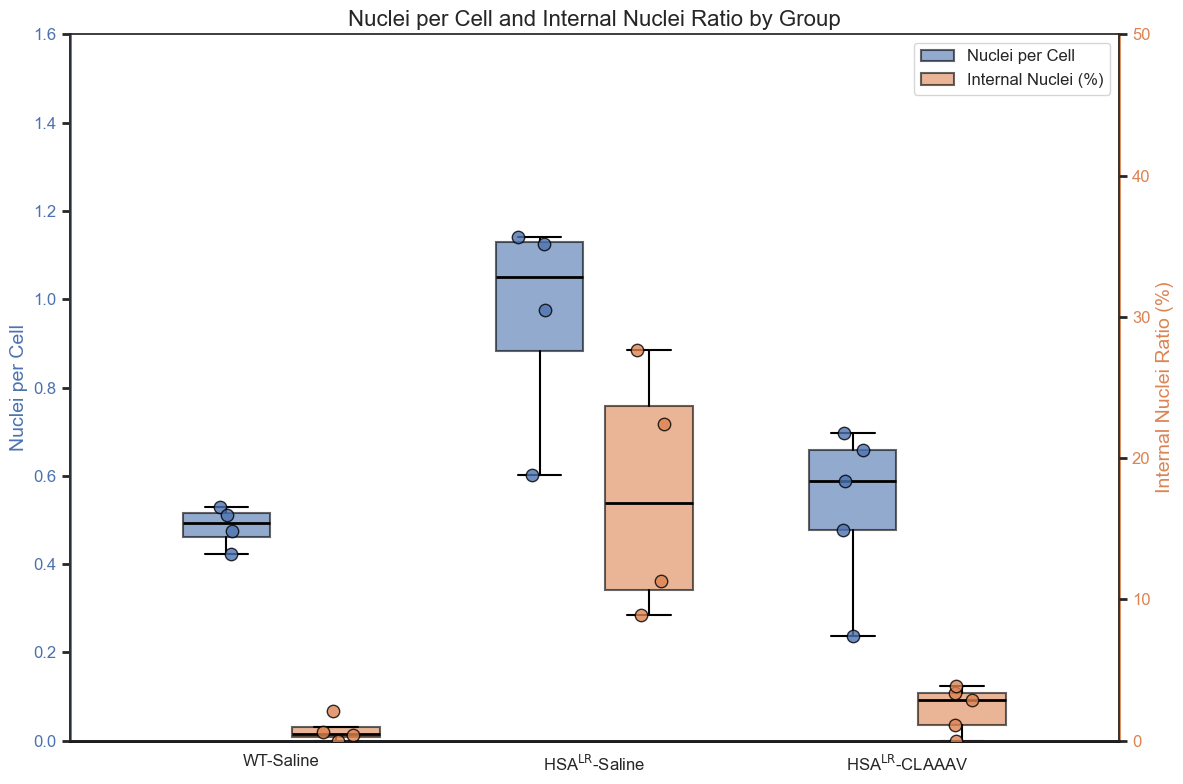

In [34]:
# 9) Simplified box plot: Nuclei per Cell and Internal Nuclei Ratio by Group (Dual Y-Axes)
# Prepare data for box plot
import matplotlib.patches as mpatches

# Create long-form data for plotting
plot_data = []
for _, row in slide_agg.iterrows():
    plot_data.append({
        'group': row['group'],
        'metric': 'Nuclei per Cell',
        'value': row['nuclei_per_cell']
    })
    plot_data.append({
        'group': row['group'],
        'metric': 'Internal Nuclei (%)',
        'value': row['internal_ratio_pct']
    })

plot_df_box = pd.DataFrame(plot_data)

# Create the plot with dual y-axes
sns.set_style('white')
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))
ax2 = ax1.twinx()  # Create second y-axis

# Define group order and positions
order = ['WT-Saline', r'HSA$^{\mathrm{LR}}$-Saline', r'HSA$^{\mathrm{LR}}$-CLAAAV']
colors = {'Nuclei per Cell': '#4C72B0', 'Internal Nuclei (%)': '#DD8452'}

# Create positions for grouped box plots
width = 0.35
x_positions = np.arange(len(order))

# Prepare data for each metric
nuclei_per_cell_data = [plot_df_box[(plot_df_box['group'] == g) & (plot_df_box['metric'] == 'Nuclei per Cell')]['value'].values 
                         for g in order]
internal_ratio_data = [plot_df_box[(plot_df_box['group'] == g) & (plot_df_box['metric'] == 'Internal Nuclei (%)')]['value'].values 
                        for g in order]

# Create box plots on first y-axis (Nuclei per Cell)
bp1 = ax1.boxplot(nuclei_per_cell_data, positions=x_positions - width/2, widths=width*0.8,
                  patch_artist=True, showfliers=False, 
                  boxprops=dict(facecolor=colors['Nuclei per Cell'], alpha=0.6, edgecolor='black', linewidth=1.5),
                  whiskerprops=dict(color='black', linewidth=1.5),
                  capprops=dict(color='black', linewidth=1.5),
                  medianprops=dict(color='black', linewidth=2))

# Create box plots on second y-axis (Internal Nuclei %)
bp2 = ax2.boxplot(internal_ratio_data, positions=x_positions + width/2, widths=width*0.8,
                  patch_artist=True, showfliers=False,
                  boxprops=dict(facecolor=colors['Internal Nuclei (%)'], alpha=0.6, edgecolor='black', linewidth=1.5),
                  whiskerprops=dict(color='black', linewidth=1.5),
                  capprops=dict(color='black', linewidth=1.5),
                  medianprops=dict(color='black', linewidth=2))

# Add individual data points
for i, group in enumerate(order):
    # Nuclei per cell points (on ax1)
    group_data_npc = plot_df_box[(plot_df_box['group'] == group) & (plot_df_box['metric'] == 'Nuclei per Cell')]['value'].values
    y_npc = group_data_npc
    x_npc = np.random.normal(x_positions[i] - width/2, 0.04, size=len(y_npc))
    ax1.scatter(x_npc, y_npc, alpha=0.8, s=80, color=colors['Nuclei per Cell'], 
               edgecolors='black', linewidth=1, zorder=3)
    
    # Internal nuclei ratio points (on ax2)
    group_data_int = plot_df_box[(plot_df_box['group'] == group) & (plot_df_box['metric'] == 'Internal Nuclei (%)')]['value'].values
    y_int = group_data_int
    x_int = np.random.normal(x_positions[i] + width/2, 0.04, size=len(y_int))
    ax2.scatter(x_int, y_int, alpha=0.8, s=80, color=colors['Internal Nuclei (%)'], 
               edgecolors='black', linewidth=1, zorder=3)

# Customize plot
ax1.set_xticks(x_positions)
ax1.set_xticklabels(order, fontsize=12)
ax1.set_ylabel('Nuclei per Cell', fontsize=14, color=colors['Nuclei per Cell'])
ax2.set_ylabel('Internal Nuclei Ratio (%)', fontsize=14, color=colors['Internal Nuclei (%)'])
ax1.set_title('Nuclei per Cell and Internal Nuclei Ratio by Group', fontsize=16)
ax1.tick_params(axis='y', labelsize=12, width=2, labelcolor=colors['Nuclei per Cell'])
ax2.tick_params(axis='y', labelsize=12, width=2, labelcolor=colors['Internal Nuclei (%)'])

# Set y-axis ranges
ax1.set_ylim(0, max(plot_df_box[plot_df_box['metric'] == 'Nuclei per Cell']['value'].max() * 1.15, 3))
ax2.set_ylim(0, 100)

# Adjust spines
ax1.spines['left'].set_linewidth(2)
ax1.spines['left'].set_color(colors['Nuclei per Cell'])
ax1.spines['right'].set_linewidth(2)
ax1.spines['right'].set_color(colors['Internal Nuclei (%)'])
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_visible(False)

# Create legend
legend_elements = [
    mpatches.Patch(facecolor=colors['Nuclei per Cell'], alpha=0.6, edgecolor='black', 
                   linewidth=1.5, label='Nuclei per Cell'),
    mpatches.Patch(facecolor=colors['Internal Nuclei (%)'], alpha=0.6, edgecolor='black', 
                   linewidth=1.5, label='Internal Nuclei (%)')
]
ax1.legend(handles=legend_elements, fontsize=12, title_fontsize=13, loc='upper right')
ax1.set_ylim(0, max(plot_df_box[plot_df_box['metric'] == 'Nuclei per Cell']['value'].max() * 1.15, 1.6))
ax2.set_ylim(0, 50)
plt.tight_layout()

# Save figure
out_path = RESULTS_FOLDER / 'boxplot_nuclei_metrics_by_group.png'
plt.savefig(out_path, dpi=600, bbox_inches='tight')
print(f"Saved box plot to: {out_path}")
plt.show()
